# RoadAI - PyTorch Classifier Implementation

RoadAI (v3) is my project submission for the Facebook Artificial Intelligence Hackathon.

`Building the most intelligent co-driver`

# Model used
VGG-19 is an excellent Convolutional Neural Network (CNN) for image classification. For the VGG-19 model, the pre-trained version that exists in PyTorch models package was used. The model was frozen to avoid changes during training. The final classifier part of the network was changed with my own light-designed classifier (100x20x2). The model was trained to distinguish between `Car` and `Red Traffic Light`.

# Training

During training, I used the pocket algorithm's idea to store and save the model with the minimum validation error to avoid overfitting during unneccesary training steps. The training was done in Google's Colab GPU Workspace.

# Results

The model had more than >85% accuracy in the test set.

In [0]:
# All Imports
import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torchvision.models as models
from collections import OrderedDict
import torch
from torch import nn
from torch import optim

In [0]:
!unzip data.zip

In [0]:
#Directories for training and validation sets
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

# Load the datasets with ImageFolder
image_datasets = torchvision.datasets.ImageFolder(data_dir)

train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=data_transforms)

# Define dataloader parameters
batch_size = 100
num_workers=0

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

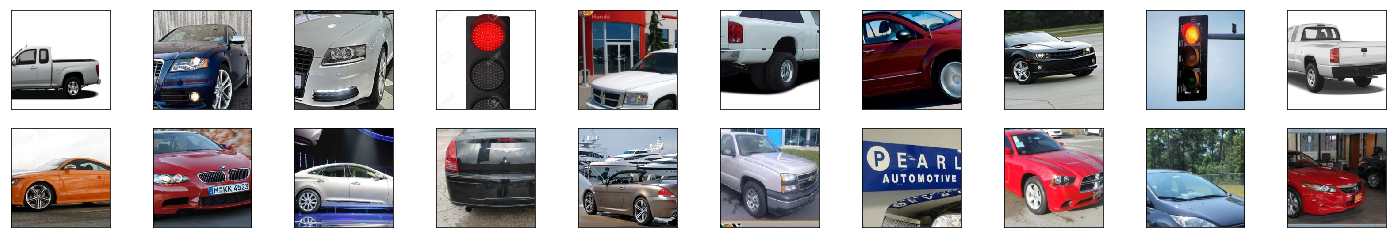

In [22]:
# Visualize some sample data

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))   

In [23]:
#Load the pretrained vgg19 model
model = models.vgg19(pretrained=True)

# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    
#Print the model's architecture
print (model)    

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [24]:
#Change the classifier's layers - Define my own classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 100)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(100, 20)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(20, 2)),
                          ('relu', nn.ReLU()), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

#Change the classifier's layers - Change the classifier section in VGG19
model.classifier = classifier

#Print the architecture of our new model
print (model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
#Define the loss and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [0]:
###----------------TRAINING----------------------##

#Hyperparameters
epochs = 10
steps = 0
running_loss = 0
print_every = 1

valid_loss_min = np.Inf # track change in validation loss

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Comment this line if train in CPU
#model.cuda();

#Training loop
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        #Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        #Forward and backward propagate the network
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        #Training loss
        running_loss += loss.item()
        
        #Validation of the model every 5 steps of training
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    #Forward and backward propagate the network
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    #Testing loss
                    test_loss += batch_loss.item()
                    
                    #Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    #Save model if validation loss has decreased
                    if test_loss <= valid_loss_min:
                        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                                valid_loss_min,
                                test_loss))
                        torch.save(model.state_dict(), 'roadai_model_new_rtl_car.pt')
                        valid_loss_min = test_loss
            
            #Print the results
            print ('Epoch:')
            print((epoch+1))
            print ('Running loss:')
            print(running_loss/print_every)
            print ('Test:')
            print(test_loss/len(test_loader))
            print ('Accuracy:')
            print(accuracy/len(test_loader))
            
            running_loss = 0
            
            #Train model
            model.train()

In [0]:
##----------Print results in validation set----------##

#Define new test model
model_test = models.vgg19(pretrained=False)
for param in model.parameters():
        param.requires_grad = False
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 100)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(100, 20)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(20, 2)),
                          ('relu', nn.ReLU()), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model_test.classifier = classifier

#Load in CPU
model_test.load_state_dict(torch.load('roadai_model_new_rtl_car.pt', map_location=lambda storage, loc: storage))

#Load in GPU
#model_test.cuda()
#model_test.load_state_dict(torch.load('roadai_model.pt'))

#Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#Move model inputs to cuda, if GPU available. Comment if in CPU
#images = images.cuda()

#Get sample outputs
output = model_test(images)
#Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

#Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format([preds[idx]], [labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))